[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Method: kmeans_forms
  Average intra-cluster distance: 0.9252311894588032
  Average inter-cluster distance: 0.7423149889431091
  Clusters:
    0: ['комментаторы_06.odt', 'комментаторы_02.odt', 'комментаторы_05.docx', 'комментаторы_01.docx']
    1: ['спортивная_медицина_07.txt', 'биохимия_04.html', 'биохимия_07.txt', 'анамнез_07.txt', 'анамнез_03.txt', 'органическая_химия_04.html', 'неорганическая_химия_03.txt', 'органическая_химия_03.txt', 'ставки_03.txt', 'анамнез_04.html', 'органическая_химия_07.txt', 'неорганическая_химия_04.html', 'комментаторы_07.txt', 'анамнез_08.html', 'комментаторы_04.html', 'ставки_07.txt', 'спортивная_медицина_04.html', 'неорганическая_химия_07.txt', 'ставки_04.html', 'биохимия_03.txt', 'спортивная_медицина_03.txt']
    2: ['биохимия_06.odt', 'биохимия_02.odt', 'органическая_химия_06.odt', 'биохимия_01.docx', 'биохимия_05.docx', 'органическая_химия_01.docx', 'анамнез_01.docx']
    3: ['спортивная_медицина_02.odt', 'спортивная_медицина_06.odt', 'спортивная_мед

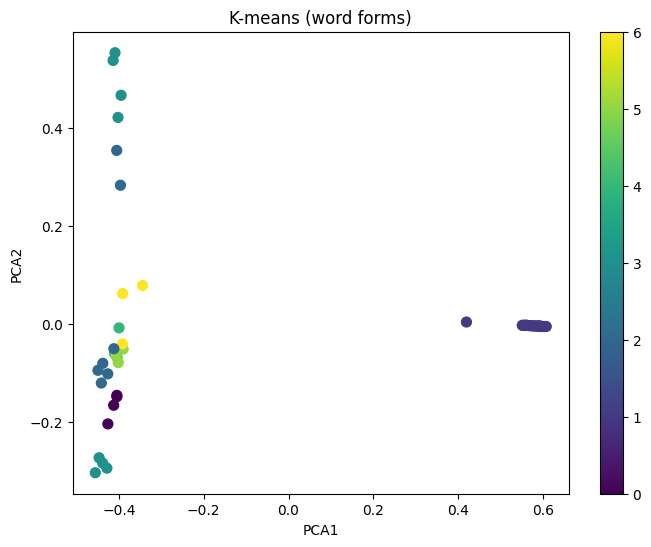

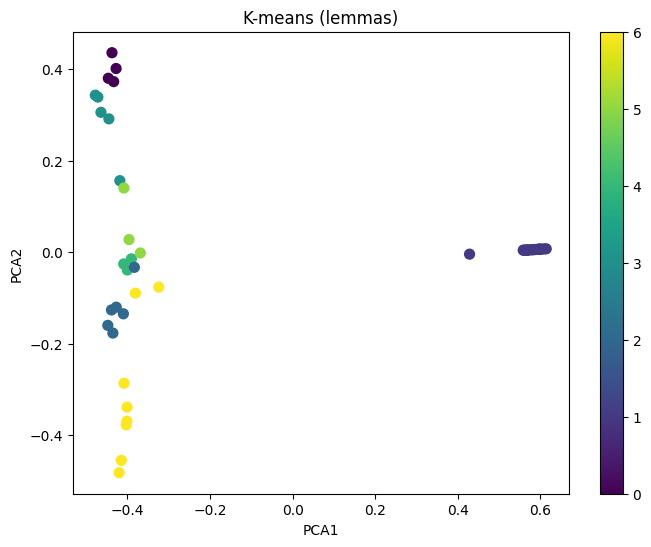

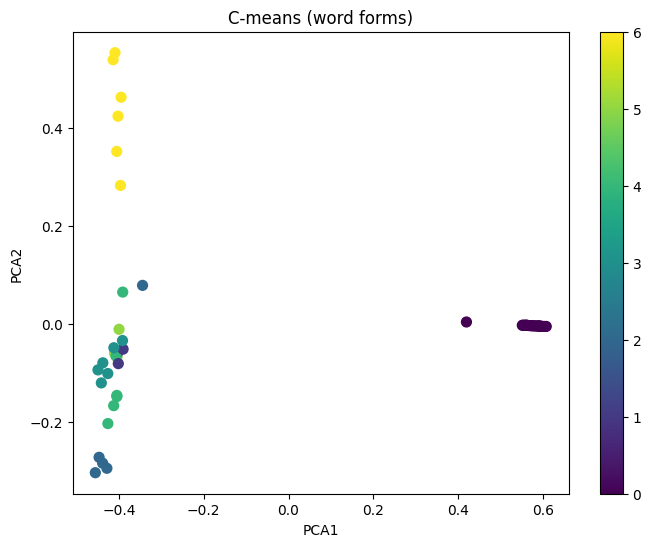

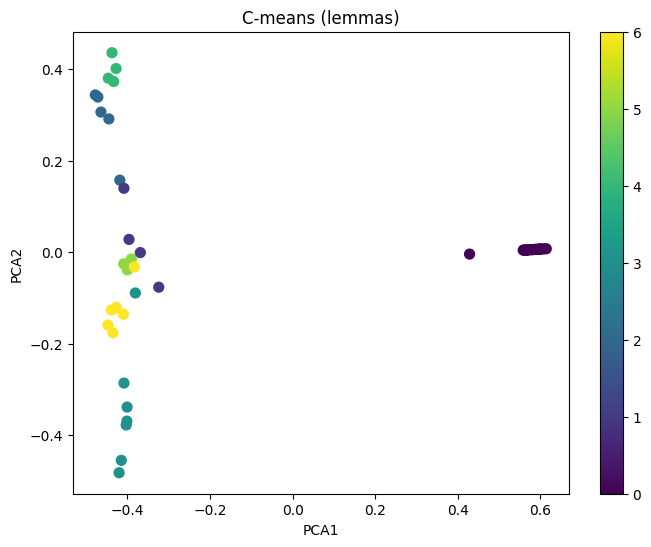

In [24]:
!pip uninstall -y enum34
!pip install scikit-learn-extra pymorphy3 python-docx odfpy

import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy3
from nltk.corpus import stopwords
import nltk

# Make sure stopwords are downloaded
nltk.download('stopwords')

def read_file(file_path):
    """
    Function to read text files of different formats
    """
    try:
        if file_path.endswith('.docx'):
            from docx import Document
            doc = Document(file_path)
            return ' '.join([para.text for para in doc.paragraphs])
        elif file_path.endswith('.odt'):
            from odf.opendocument import load
            from odf.text import P
            doc = load(file_path)
            paragraphs = doc.getElementsByType(P)
            return " ".join([str(p) for p in paragraphs if p and p.firstChild])
        elif file_path.endswith('.txt'):
            with open(file_path, 'r', encoding='latin-1') as file:
                return file.read()
        elif file_path.endswith('.html'):
            from bs4 import BeautifulSoup
            with open(file_path, 'r', encoding='latin-1') as file:
                soup = BeautifulSoup(file, 'html.parser')
                return soup.get_text()
        else:
            return ''
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return ''

def load_data(folder_path):
    texts, filenames = [], []
    for root, _, files in os.walk(folder_path):
        for file in files:
            filepath = os.path.join(root, file)
            text = read_file(filepath)
            if text:
                texts.append(text)
                filenames.append(file)
    return texts, filenames

def calculate_distances(X, labels):
    # Convert X to a dense array if it's not already
    X = X.toarray() if not isinstance(X, np.ndarray) else X

    n_clusters = len(set(labels))
    cluster_distances = []
    intra_cluster_distances = []

    for cluster in range(n_clusters):
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            # Average intra-cluster distance
            intra_dist = np.mean(pairwise_distances(cluster_points))
            intra_cluster_distances.append(intra_dist)

        # Centroid or median of the current cluster
        cluster_center = np.mean(cluster_points, axis=0)
        cluster_distances.append(cluster_center)

    # Average inter-cluster distance
    inter_cluster_distances = np.mean(pairwise_distances(cluster_distances))

    return np.mean(intra_cluster_distances), inter_cluster_distances

def print_clusters(labels):
    for cluster in range(len(set(labels))):
        print(f"    {cluster}: {[filenames[i] for i in range(len(filenames)) if labels[i] == cluster]}")

def plot_clusters(X, labels, title):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis", s=50)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.show()

folder_path = "./"  # Specify the folder path
texts, filenames = load_data(folder_path)

# Vectorization
# 1. Vectorization by word forms
vectorizer_forms = TfidfVectorizer(max_features=5000)
X_forms = vectorizer_forms.fit_transform(texts)

# 2. Lemmatization of the text
morph = pymorphy3.MorphAnalyzer()
lemmatized_texts = [' '.join([morph.parse(word)[0].normal_form for word in text.split()]) for text in texts]
vectorizer_lemmas = TfidfVectorizer(max_features=5000)
X_lemmas = vectorizer_lemmas.fit_transform(lemmatized_texts)

# Clustering
n_clusters = 7
labels = {}

# 1. K-means for word forms
kmeans_forms = KMeans(n_clusters=n_clusters, random_state=42)
labels["kmeans_forms"] = kmeans_forms.fit_predict(X_forms)

# 2. K-means for lemmas
kmeans_lemmas = KMeans(n_clusters=n_clusters, random_state=42)
labels["kmeans_lemmas"] = kmeans_lemmas.fit_predict(X_lemmas)

# 3. C-means for word forms
cmedoids_forms = KMedoids(n_clusters=n_clusters, random_state=42, method="pam")
labels["cmedoids_forms"] = cmedoids_forms.fit_predict(X_forms)

# 4. C-means for lemmas
cmedoids_lemmas = KMedoids(n_clusters=n_clusters, random_state=42, method="pam")
labels["cmedoids_lemmas"] = cmedoids_lemmas.fit_predict(X_lemmas)

# Calculating metrics
metrics = {
    "kmeans_forms": calculate_distances(X_forms, labels["kmeans_forms"]),
    "kmeans_lemmas": calculate_distances(X_lemmas, labels["kmeans_lemmas"]),
    "cmedoids_forms": calculate_distances(X_forms, labels["cmedoids_forms"]),
    "cmedoids_lemmas": calculate_distances(X_lemmas, labels["cmedoids_lemmas"]),
}

# Display results
for method, (intra_dist, inter_dist) in metrics.items():
    print(f"Method: {method}")
    print(f"  Average intra-cluster distance: {intra_dist}")
    print(f"  Average inter-cluster distance: {inter_dist}")
    print(f"  Clusters:")
    print_clusters(labels[method])
    print("\n")

# Visualization for each method
plot_clusters(X_forms, labels["kmeans_forms"], "K-means (word forms)")
plot_clusters(X_lemmas, labels["kmeans_lemmas"], "K-means (lemmas)")
plot_clusters(X_forms, labels["cmedoids_forms"], "C-means (word forms)")
plot_clusters(X_lemmas, labels["cmedoids_lemmas"], "C-means (lemmas)")
